# [실습] 그래프에 메모리 추가하기   

랭그래프의 메모리 기능을 통해, 이전의 실행 내용을 기억하도록 설정할 수 있습니다.   

세션 내부의 단기 기억에 해당하는 Checkpoint와, 장기 기억에 해당하는 Storage를 사용합니다.
<br><br>

**이번 실습은 GPU가 필요합니다. 오른쪽 탭의 "런타임 유형 변경"을 통해 T4 GPU로 체크하고 진행해 주세요!**






기본 라이브러리를 설치합니다.

In [1]:
!pip install langgraph langchain langchain_google_genai langchain_community langgraph-checkpoint-sqlite rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.8/449.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.0.1
    Uninstalling langchain-core-1.0.1:
      Successfully uninstalled langchain-core-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 1.0.0 requires langchain-core<2.0.0,>=1.0.0, but you have langchain-core 0.3.79 which is incompatible.


API 키와 LLM을 구성합니다.

In [2]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

중간 과정 확인을 위해, LangSmith를 연동합니다.
https://smith.langchain.com 에서 등록 후 작성합니다.

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = ''
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

## Checkpoint(체크포인트)

체크포인트는 그래프 실행의 상태와 중간 단계를 저장하고 관리합니다.    

<br><br>체크포인트를 저장하기 위해 MemorySaver를 구성합니다.

In [4]:
# 메모리 세팅
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

구성된 체크포인터는 `compile`에 포함하여 실행하면 됩니다.

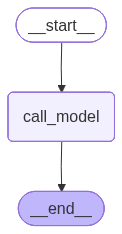

In [5]:
from typing import Annotated
from typing_extensions import TypedDict, List
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, state, START

class State(TypedDict):
    messages: Annotated[list, add_messages]
    foo: str


def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}


builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
graph = builder.compile(checkpointer=memory)

graph
# memory에 기록 저장

체크포인터에서, 각각의 실행은 `thread`라는 이름으로 구분됩니다.   
thread_id를 활용해, 이전 출력의 정보를 저장할 수 있습니다.

In [6]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# thread_id를 통해 매 실행의 체크포인트 저장
config = {"configurable": {"thread_id": "1"}}


input_message = HumanMessage(input())

for chunk in graph.stream({"messages": [input_message]},
                          config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

안녕, 나는 랭그래프 공부중이야
================================ Human Message =================================

안녕, 나는 랭그래프 공부중이야
================================== Ai Message ==================================

안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 라이브러리죠.

어떤 부분에 대해 궁금하신가요?

*   랭그래프의 기본 개념
*   상태(State)와 노드(Node), 엣지(Edge)
*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)
*   에이전트(Agent) 구현
*   특정 예제나 사용 사례
*   어려움을 겪고 있는 부분

어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊


In [7]:
input_message = {"role": "user", "content": "내가 뭐라고 했지?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

내가 뭐라고 했지?
================================== Ai Message ==================================

네, **"안녕, 나는 랭그래프 공부중이야"** 라고 말씀하셨습니다. 😊


해당 체크포인트의 내용은 `thread_id`에 귀속됩니다.

In [8]:
config = {"configurable": {"thread_id": "2"}}

input_message = {"role": "user", "content": "내가 뭐라고 했지?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

내가 뭐라고 했지?
================================== Ai Message ==================================

저는 이전 대화 내용을 기억하지 못합니다. 제가 받은 마지막 질문이나 말씀하신 내용을 다시 한번 알려주시면 제가 더 정확하게 답변해 드릴 수 있습니다.


`get_state`를 통해 진행된 스레드의 마지막 상태를 볼 수 있습니다.   
해당 상태에는 State의 스냅샷 정보가 저장되어 있습니다.

In [9]:
from rich import print as rprint
config = {"configurable": {"thread_id": "1"}}

rprint(graph.get_state(config))

StateSnapshot(
    values={
        'messages': [
            HumanMessage(
                content='안녕, 나는 랭그래프 공부중이야',
                additional_kwargs={},
                response_metadata={},
                id='0b32bb3b-5086-4272-bf59-6336cf388f8d'
            ),
            AIMessage(
                content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 
라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 
엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 
사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'model_name': 'gemini-2.5-flash',
                    'safety_ratings': []
                },
                id='run--393f660d-2e9e-4993-9150-262bab3478e6-0',
                usage_metadata={
                    'input_tokens': 12,
                    'output_tokens': 644,
                    'total_tokens': 656,
                    'input_token_details': {'cache_read': 0},
                    'output_token_details': {'reasoning': 501}
                }
            ),
            HumanMessage(
                content='내가 뭐라고 했지?',
                additional_kwargs={},
                response_metadata={},
                id='b37898ed-ec49-4e25-b168-35243b797598'
            ),
            AIMessage(
                content='네, **"안녕, 나는 랭그래프 공부중이야"** 라고 말씀하셨습니다. 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'model_name': 'gemini-2.5-flash',
                    'safety_ratings': []
                },
                id='run--c834a92e-520f-4c3d-a978-16d6392f191f-0',
                usage_metadata={
                    'input_tokens': 162,
                    'output_tokens': 56,
                    'total_tokens': 218,
                    'input_token_details': {'cache_read': 0},
                    'output_token_details': {'reasoning': 32}
                }
            )
        ]
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0b22d1-4119-683f-8004-fca6b4896704'
        }
    },
    metadata={'source': 'loop', 'step': 4, 'parents': {}},
    created_at='2025-10-26T05:31:52.845508+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0b22d1-2b78-6bfd-8003-65870c86f054'
        }
    },
    tasks=(),
    interrupts=()
)

`get_state_history()`는 전체 스냅샷 목록을 순서대로 보여줍니다.

In [10]:
history = list(graph.get_state_history(config))
history

[StateSnapshot(values={'messages': [HumanMessage(content='안녕, 나는 랭그래프 공부중이야', additional_kwargs={}, response_metadata={}, id='0b32bb3b-5086-4272-bf59-6336cf388f8d'), AIMessage(content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--393f660d-2e9e-4993-9150-262bab3478e6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 644, 'total_tokens': 656, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 501}}), HumanMessage(content='내가 뭐라고 했지?', additional_kwargs={}, response_metadata={}, id='b37898ed-ec49-4e25-b168-35243b797598'), AIMessage(content='

In [11]:
for i in range(len(history)):
    print(history[i].config, len(history[i].values['messages']))
    # 메시지 개수와 config 정보

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22d1-4119-683f-8004-fca6b4896704'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22d1-2b78-6bfd-8003-65870c86f054'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22d1-2b73-6a2c-8002-0bb8839c1b6e'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22d1-2b5c-66d8-8001-04d487a0728e'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22d0-c86e-6dd9-8000-5043d4825f1a'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22d0-c86b-6b15-bfff-867073a4ab1f'}} 0


## Replay

위에서 얻은 Snapshot을 활용하면, 특정 시점부터 시작하는 것도 가능합니다.   

In [12]:
history[1].values

{'messages': [HumanMessage(content='안녕, 나는 랭그래프 공부중이야', additional_kwargs={}, response_metadata={}, id='0b32bb3b-5086-4272-bf59-6336cf388f8d'),
  AIMessage(content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--393f660d-2e9e-4993-9150-262bab3478e6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 644, 'total_tokens': 656, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 501}}),
  HumanMessage(content='내가 뭐라고 했지?', additional_kwargs={}, response_metadata={}, id='b37898ed-ec49-4e25-b168-35243b797598')]}

HumanMessage의 특정 시점부터 재시작합니다.

In [13]:
graph.invoke(None, config = history[1].config)

{'messages': [HumanMessage(content='안녕, 나는 랭그래프 공부중이야', additional_kwargs={}, response_metadata={}, id='0b32bb3b-5086-4272-bf59-6336cf388f8d'),
  AIMessage(content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--393f660d-2e9e-4993-9150-262bab3478e6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 644, 'total_tokens': 656, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 501}}),
  HumanMessage(content='내가 뭐라고 했지?', additional_kwargs={}, response_metadata={}, id='b37898ed-ec49-4e25-b168-35243b797598'),
  AIMessage(content='네, 당신은 **"안녕, 나는

Replay를 수행하면, graph의 history에는 해당 실행 결과가 추가됩니다.

In [14]:
history = list(graph.get_state_history(config))
history

[StateSnapshot(values={'messages': [HumanMessage(content='안녕, 나는 랭그래프 공부중이야', additional_kwargs={}, response_metadata={}, id='0b32bb3b-5086-4272-bf59-6336cf388f8d'), AIMessage(content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--393f660d-2e9e-4993-9150-262bab3478e6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 644, 'total_tokens': 656, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 501}}), HumanMessage(content='내가 뭐라고 했지?', additional_kwargs={}, response_metadata={}, id='b37898ed-ec49-4e25-b168-35243b797598'), AIMessage(content='

특정 스냅샷의 값을 수정할 수도 있습니다. 이 경우, Reducer의 정의에 맞게 처리됩니다.

In [15]:
graph.update_state(config = history[0].config, values= {'messages':'저녁 뭐 먹을까?'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b22d1-bd52-6980-8005-8f319649e8ce'}}

In [16]:
history = list(graph.get_state_history(config))
rprint(history[0])

StateSnapshot(
    values={
        'messages': [
            HumanMessage(
                content='안녕, 나는 랭그래프 공부중이야',
                additional_kwargs={},
                response_metadata={},
                id='0b32bb3b-5086-4272-bf59-6336cf388f8d'
            ),
            AIMessage(
                content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 
라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 
엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 
사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'model_name': 'gemini-2.5-flash',
                    'safety_ratings': []
                },
                id='run--393f660d-2e9e-4993-9150-262bab3478e6-0',
                usage_metadata={
                    'input_tokens': 12,
                    'output_tokens': 644,
                    'total_tokens': 656,
                    'input_token_details': {'cache_read': 0},
                    'output_token_details': {'reasoning': 501}
                }
            ),
            HumanMessage(
                content='내가 뭐라고 했지?',
                additional_kwargs={},
                response_metadata={},
                id='b37898ed-ec49-4e25-b168-35243b797598'
            ),
            AIMessage(
                content='네, 당신은 **"안녕, 나는 랭그래프 공부중이야"** 라고 말씀하셨습니다. 😊',
                additional_kwargs={},
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'model_name': 'gemini-2.5-flash',
                    'safety_ratings': []
                },
                id='run--401472a0-0498-4cbb-ace2-7340ec0a7815-0',
                usage_metadata={
                    'input_tokens': 162,
                    'output_tokens': 121,
                    'total_tokens': 283,
                    'input_token_details': {'cache_read': 0},
                    'output_token_details': {'reasoning': 95}
                }
            ),
            HumanMessage(
                content='저녁 뭐 먹을까?',
                additional_kwargs={},
                response_metadata={},
                id='ae41e709-1047-43b6-9e3b-b6ad690a1289'
            )
        ]
    },
    next=(),
    config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0b22d1-bd52-6980-8005-8f319649e8ce'
        }
    },
    metadata={'source': 'update', 'step': 5, 'parents': {}},
    created_at='2025-10-26T05:32:05.871227+00:00',
    parent_config={
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1f0b22d1-bd08-6fe6-8004-6673c712daba'
        }
    },
    tasks=(),
    interrupts=()
)

In [17]:
graph.invoke(None, config = history[0].config)

{'messages': [HumanMessage(content='안녕, 나는 랭그래프 공부중이야', additional_kwargs={}, response_metadata={}, id='0b32bb3b-5086-4272-bf59-6336cf388f8d'),
  AIMessage(content='안녕하세요! 랭그래프(LangGraph)를 공부하고 계시는군요! 정말 흥미롭고 유용한 라이브러리죠.\n\n어떤 부분에 대해 궁금하신가요?\n\n*   랭그래프의 기본 개념\n*   상태(State)와 노드(Node), 엣지(Edge)\n*   다양한 그래프 구성 방식 (선형, 조건부 로직 등)\n*   에이전트(Agent) 구현\n*   특정 예제나 사용 사례\n*   어려움을 겪고 있는 부분\n\n어떤 질문이든 편하게 해주세요! 아는 범위 내에서 최대한 도와드리겠습니다. 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--393f660d-2e9e-4993-9150-262bab3478e6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 644, 'total_tokens': 656, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 501}}),
  HumanMessage(content='내가 뭐라고 했지?', additional_kwargs={}, response_metadata={}, id='b37898ed-ec49-4e25-b168-35243b797598'),
  AIMessage(content='네, 당신은 **"안녕, 나는

## SQLite를 이용한 Checkpointing

`SqliteSaver`를 사용해, 체크포인팅을 저장할 수 있습니다.

In [18]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
checkpointer = SqliteSaver(conn)

graph = builder.compile(checkpointer=checkpointer)


In [19]:
config = {"configurable": {"thread_id": "1"}}


input_message = HumanMessage(input())

for chunk in graph.stream({"messages": [input_message]},
                          config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

안녕, 나는 타코를 좋아해.
================================ Human Message =================================

안녕, 나는 타코를 좋아해.
================================== Ai Message ==================================

네, 안녕하세요! 다시 만나서 반가워요! 🌮

타코를 좋아하시는군요! 저도 정말 좋아해요. 어떤 점이 타코를 그렇게 좋아하게 만드나요?

*   바삭한 쉘이나 부드러운 또띠아?
*   매콤한 살사 소스?
*   다양한 고기와 신선한 채소의 조합?
*   아니면 그 모든 것?

타코에 대한 이야기를 더 듣고 싶어요! 😊


In [20]:
input_message = {"role": "user", "content": "오늘 저녁은 뭐 먹을까?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

오늘 저녁은 뭐 먹을까?
================================== Ai Message ==================================

네, 타코를 좋아하신다고 하셨으니, 오늘 저녁은 **타코**를 중심으로 생각해 보는 건 어떠세요? 🌮

**1. 타코의 즐거움을 다시 한번!**

*   **홈메이드 타코:** 직접 재료를 준비해서 만드는 재미도 쏠쏠해요! 소고기, 닭고기, 돼지고기(카르니타스), 새우, 혹은 채식(콩, 버섯) 등 좋아하는 재료를 듬뿍 넣고 살사, 과카몰리, 사워크림, 양파, 고수 등을 곁들이면 정말 맛있죠.
*   **타코 전문점 방문 또는 배달:** 오늘은 좀 편하게 즐기고 싶다면, 맛있는 타코 전문점에서 다양한 종류의 타코를 시켜 드시는 것도 좋아요. 멕시칸 그릴이나 푸드트럭 같은 곳도 좋은 옵션이 될 수 있구요!

**2. 타코와 찰떡궁합 멕시칸 메뉴!**

타코를 좋아하신다면 분명 다른 멕시칸 음식도 입맛에 맞으실 거예요!

*   **부리또/부리또 볼:** 밥, 콩, 고기, 채소 등을 또띠아에 싸거나 그릇에 담아 푸짐하게 즐길 수 있어요.
*   **퀘사디아:** 치즈와 속재료를 또띠아 사이에 넣고 구운 것. 간단하지만 만족감이 높아요.
*   **파히타:** 철판에 지글지글 볶은 고기와 채소를 또띠아에 싸 먹는 재미가 있죠.

**3. 만약 타코 말고 다른 게 당기신다면...**

혹시 타코와 비슷한 느낌이지만 다른 것을 원하시거나, 완전히 다른 음식이 당기실 수도 있으니 몇 가지 더 제안해 드릴게요.

*   **샌드위치/랩:** 타코처럼 손으로 들고 먹는 편한 음식을 좋아하시면, 든든한 랩 샌드위치도 괜찮아요.
*   **매콤한 한식:** 타코의 살사처럼 매콤한 맛을 좋아하신다면 김치찌개, 닭볶음탕 같은 한식도 좋은 선택이에요.
*   **파스타/피

## Store를 이용한 장기 메모리 추가하기   

Thread Checkpoint는 단일 세션의 메모리를 저장하기에는 효과적이지만,   
세션이 유지되지 않는 경우에는 다른 방법이 필요합니다.   

InMemoryStore를 통해, 장기 메모리를 추가할 수 있습니다.


In [21]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

Namespace를 통해 메모리 위치를 설정합니다.

In [22]:
namespace_for_memory = ('1', 'memories')

In [23]:
import uuid
memory_id = str(uuid.uuid4())

memory = {'information' : "지금은 랭그래프 메모리 실습 중입니다."}
in_memory_store.put(namespace_for_memory, memory_id, memory)
memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='7f5278f1-3552-41be-b5cf-82ec0714fc59', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-10-26T05:32:24.624090+00:00', updated_at='2025-10-26T05:32:24.624092+00:00', score=None)]

In [24]:
memory = {'name' : "FastCampus"}
memory_id = str(uuid.uuid4())

in_memory_store.put(namespace_for_memory, memory_id, memory)
# memory_id에 매핑되는 구조

memories = in_memory_store.search(namespace_for_memory)
memories


[Item(namespace=['1', 'memories'], key='7f5278f1-3552-41be-b5cf-82ec0714fc59', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-10-26T05:32:24.624090+00:00', updated_at='2025-10-26T05:32:24.624092+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e20add15-42a4-410a-9e58-4ea7b38c9167', value={'name': 'FastCampus'}, created_at='2025-10-26T05:32:24.630916+00:00', updated_at='2025-10-26T05:32:24.630918+00:00', score=None)]

In [25]:
# 메모리 레코드 추가하기
memory_id = str(uuid.uuid4())
new_memory  = {'name' : "LangGraph"}

in_memory_store.put(namespace_for_memory, memory_id, new_memory)
# memory_id에 매핑되는 구조

memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='7f5278f1-3552-41be-b5cf-82ec0714fc59', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-10-26T05:32:24.624090+00:00', updated_at='2025-10-26T05:32:24.624092+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e20add15-42a4-410a-9e58-4ea7b38c9167', value={'name': 'FastCampus'}, created_at='2025-10-26T05:32:24.630916+00:00', updated_at='2025-10-26T05:32:24.630918+00:00', score=None),
 Item(namespace=['1', 'memories'], key='5ea85394-4c2f-4a2c-af26-1c1d0550cd29', value={'name': 'LangGraph'}, created_at='2025-10-26T05:32:24.636658+00:00', updated_at='2025-10-26T05:32:24.636660+00:00', score=None)]

In [26]:
# 메모리 덮어씌우기
new_memory  = {'name' : "패스트캠퍼스"}

in_memory_store.put(namespace_for_memory, memory_id, new_memory)
# memory_id에 매핑되는 구조

memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='7f5278f1-3552-41be-b5cf-82ec0714fc59', value={'information': '지금은 랭그래프 메모리 실습 중입니다.'}, created_at='2025-10-26T05:32:24.624090+00:00', updated_at='2025-10-26T05:32:24.624092+00:00', score=None),
 Item(namespace=['1', 'memories'], key='e20add15-42a4-410a-9e58-4ea7b38c9167', value={'name': 'FastCampus'}, created_at='2025-10-26T05:32:24.630916+00:00', updated_at='2025-10-26T05:32:24.630918+00:00', score=None),
 Item(namespace=['1', 'memories'], key='5ea85394-4c2f-4a2c-af26-1c1d0550cd29', value={'name': '패스트캠퍼스'}, created_at='2025-10-26T05:32:24.642467+00:00', updated_at='2025-10-26T05:32:24.642469+00:00', score=None)]

In [27]:
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '5ea85394-4c2f-4a2c-af26-1c1d0550cd29',
 'value': {'name': '패스트캠퍼스'},
 'created_at': '2025-10-26T05:32:24.642467+00:00',
 'updated_at': '2025-10-26T05:32:24.642469+00:00',
 'score': None}

## memory 검색    
메모리에 임베딩 모델을 설정하면 임베딩 기반의 인덱싱/검색이 가능합니다.    
주로 사용할 수 있는 다국어 임베딩은 다음과 같습니다.   
1. 온라인/ OpenAI의 `text-embedding-3-small`, `text-embedding-3-large` (유료)
2. 온라인/ Google `gemini-embedding-exp-03-07` (유료, 무료 제한 1일 100개)
3. 오프라인/ HuggingFace에서 지원하는 `bge-m3`, `multilingual-e5`, `KURE-v1`    

이번 실습에서는 가장 작은 임베딩 모델 중 하나인 `text-embedding-3-small`를 사용합니다.   

**실제 임베딩 모델을 선정하실 때는 GPU 자원에 따라 MTEB 리더보드 (https://huggingface.co/spaces/mteb/leaderboard) 에서 한국어 성능 순위를 참고하시는 것을 추천합니다!**

In [28]:
!pip install langchain-huggingface sentence-transformers

  Using cached langchain_core-1.0.1-py3-none-any.whl.metadata (3.5 kB)
Using cached langchain_core-1.0.1-py3-none-any.whl (467 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.1 which is incompatible.


HuggingFace에서 임베딩을 다운로드하여 로컬 폴더에 저장합니다.

In [29]:
from sentence_transformers import SentenceTransformer

# HuggingFace 임베딩 주소 지정하기
# nlpai-lab/KURE-v1 , baai/bge-m3, 등의 주소를 입력하여 지정

model_name = 'intfloat/multilingual-e5-small'

# CPU 설정으로 모델 불러오기
# device='cuda'로 변경하면 GPU에서 로드
emb_model = SentenceTransformer(model_name, device='cpu')

# 로컬 폴더에 모델 저장하기
emb_model.save('./embedding')
del emb_model

import gc
gc.collect()
# 메모리 정리하기

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

4110

In [30]:
from langchain_huggingface import HuggingFaceEmbeddings

# 허깅페이스 포맷의 임베딩 모델 불러오기
embeddings = HuggingFaceEmbeddings(model_name= './embedding',
                                   model_kwargs={'device':'cuda'})
# GPU가 있는 경우, CUDA(GPU) 설정

In [31]:
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1024, # 임베딩 차원(모델마다 다름)
        "fields": ["comments"] # 임베딩을 활용해 저장할 필드 지정
    }
)

In [32]:
memory_id

'5ea85394-4c2f-4a2c-af26-1c1d0550cd29'

In [33]:
namespace_for_memory = ('1', 'information')
memory_id = str(uuid.uuid4())

store.put(namespace_for_memory,
          memory_id,
          {'ID':'JohnDoe1', 'comments':'안녕하세요! 저는 John Doe이고, 23살입니다.'})

store.search(namespace_for_memory, limit=20)

[Item(namespace=['1', 'information'], key='15f64ae9-0d72-4440-a559-17aeda614b99', value={'ID': 'JohnDoe1', 'comments': '안녕하세요! 저는 John Doe이고, 23살입니다.'}, created_at='2025-10-26T05:33:15.617568+00:00', updated_at='2025-10-26T05:33:15.617575+00:00', score=None)]

In [34]:
def add_records(store, namespace, data_records):
    for data in data_records:
        store.put(namespace, str(uuid.uuid4()), data)

example_data = [
    {'Hello':'world'},
    {'ID':'Admin', 'comments':'이 계정은 운영 전용 계정입니다.'},
    {'ID':'GPT_Agent1', 'comments':'GPT-4o Agent 전용 계정'},
    {'ID':'Gemini_Agent1', 'comments':'Gemini-2.0-flash Agent 전용 계정'}
]

add_records(store,namespace_for_memory, example_data)


history = store.search(namespace_for_memory)
history

[Item(namespace=['1', 'information'], key='15f64ae9-0d72-4440-a559-17aeda614b99', value={'ID': 'JohnDoe1', 'comments': '안녕하세요! 저는 John Doe이고, 23살입니다.'}, created_at='2025-10-26T05:33:15.617568+00:00', updated_at='2025-10-26T05:33:15.617575+00:00', score=None),
 Item(namespace=['1', 'information'], key='54379159-e0e9-4608-9f7f-770d7b02ebc1', value={'Hello': 'world'}, created_at='2025-10-26T05:33:15.647921+00:00', updated_at='2025-10-26T05:33:15.647932+00:00', score=None),
 Item(namespace=['1', 'information'], key='43e4971e-7b56-446e-b572-d575a8737782', value={'ID': 'Admin', 'comments': '이 계정은 운영 전용 계정입니다.'}, created_at='2025-10-26T05:33:15.670042+00:00', updated_at='2025-10-26T05:33:15.670045+00:00', score=None),
 Item(namespace=['1', 'information'], key='53a1db81-b3e3-48ae-bbee-392d4b2ddd96', value={'ID': 'GPT_Agent1', 'comments': 'GPT-4o Agent 전용 계정'}, created_at='2025-10-26T05:33:15.686779+00:00', updated_at='2025-10-26T05:33:15.686781+00:00', score=None),
 Item(namespace=['1', 'infor

In [35]:
print('\n'.join(['['+str(i.created_at)[0:10] + '] ' + i.value['comments'] if 'comments' in i.value else '' for i in history]))

[2025-10-26] 안녕하세요! 저는 John Doe이고, 23살입니다.

[2025-10-26] 이 계정은 운영 전용 계정입니다.
[2025-10-26] GPT-4o Agent 전용 계정
[2025-10-26] Gemini-2.0-flash Agent 전용 계정


In [36]:
result = store.search(
    namespace_for_memory,
    query = 'Gemini Agent 버전은 뭔가요?',
    limit = 2
)
result

[Item(namespace=['1', 'information'], key='84c37fc1-7890-45dc-9a10-c00f4d4c93cd', value={'ID': 'Gemini_Agent1', 'comments': 'Gemini-2.0-flash Agent 전용 계정'}, created_at='2025-10-26T05:33:15.703512+00:00', updated_at='2025-10-26T05:33:15.703514+00:00', score=0.894333969781483),
 Item(namespace=['1', 'information'], key='53a1db81-b3e3-48ae-bbee-392d4b2ddd96', value={'ID': 'GPT_Agent1', 'comments': 'GPT-4o Agent 전용 계정'}, created_at='2025-10-26T05:33:15.686779+00:00', updated_at='2025-10-26T05:33:15.686781+00:00', score=0.8406650756732776)]

In [37]:
type(result[0])

langgraph.store.base.SearchItem

이렇게 생성된 store는 각 Node에 State와 함께 포함할 수 있습니다.  
실제 채팅 시나리오를 통해 구현해 보겠습니다.

In [38]:
from langgraph.checkpoint.sqlite import SqliteSaver


memory = MemorySaver()
in_memory_store = InMemoryStore()

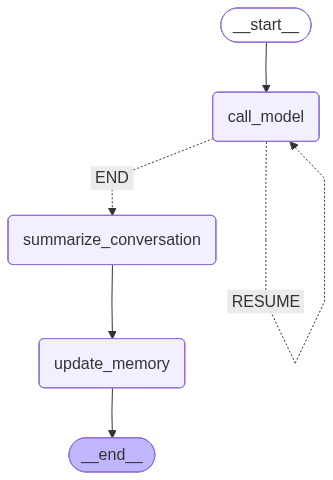

In [39]:
from typing import Annotated
from typing_extensions import TypedDict, List
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, state, START, END
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig


class State(TypedDict):
    messages: Annotated[list, add_messages]
    summary: str



def call_model(state: State, config: RunnableConfig, store: BaseStore):

    user_id = config['configurable']['user_id']
    namespace = (user_id, "information")

    def gen_memories(history):
        return '\n'.join(['['+str(i.created_at)[0:10] + '] ' + i.value['memory'] if 'memory' in i.value else '' for i in history])

    summary = gen_memories(store.search(namespace))

    prompt = [SystemMessage(content=f"""
당신은 고객 상담 챗봇입니다.
고객은 이전에 아래의 상담을 한 적이 있습니다. 과거 내역을 참고하여 응답하세요.
첫 대화는 친절한 인사로 시작하세요.
---
Previous Conversation Summary: {summary}"""), HumanMessage(content="안녕하세요!")] + state['messages']

     # 과거 정보를 상위 Context에 포함하기
    response = llm.invoke(prompt)
    print('Assistant:', response.content)

    user_message = HumanMessage(content = input())


    return {"messages": [response, user_message]}

def summarize_conversation(state: State, config: RunnableConfig, store: BaseStore):

    summary_prompt = """현재까지의 대화 내용을 요약하여 데이터베이스에 저장하려고 합니다.
이전의 Summary 내용과 이어지는 경우, 해당 내용을 포함하여 요약하세요.
만약 새로운 주제인 경우, 새로운 대화 내용만 요약하세요.
대화 내용을 3~5문장 길이로 요약하세요. 요약 이외의 다른 내용은 출력하지 마세요.
또한, 요약을 요청했다는 사실도 작성하지 마세요.
"""
    prompt = state['messages'][:-1] + [HumanMessage(content = summary_prompt)]
    # END 제외

    response = llm.invoke(prompt)

    delete_messages = [RemoveMessage(id=m.id) for m in state['messages']]
    return {'summary': response.content, 'messages':delete_messages}



def update_memory(state:State, config: RunnableConfig, store:BaseStore):

    user_id = config['configurable']['user_id']
    namespace = (user_id, "information")

    memory_id = str(uuid.uuid4())


    memory = state["summary"]

    store.put(namespace, memory_id, {'memory':memory})

def check_end(state:State):
    last_msg = state["messages"][-1]

    if last_msg.content.upper()=='END':
        return 'END'
    return 'RESUME'

builder = StateGraph(State)


builder.add_node('update_memory', update_memory)
builder.add_node("call_model", call_model)
builder.add_node('summarize_conversation', summarize_conversation)

builder.add_edge(START, "call_model")
builder.add_conditional_edges('call_model',
                              check_end,
                              {'END':'summarize_conversation',
                               'RESUME':'call_model'})
builder.add_edge('summarize_conversation','update_memory')
builder.add_edge('update_memory', END)

graph = builder.compile(checkpointer=memory, store=in_memory_store)

graph
# memory에 기록 저장

In [40]:
print('END를 입력하면 대화가 종료됩니다.')

config = {'configurable':{'thread_id':'2', 'user_id':'admin'}}
for data in graph.stream(
    {'messages':[]},
    config,stream_mode="updates"):
    print(data)

END를 입력하면 대화가 종료됩니다.
Assistant: 안녕하세요! 고객님, 무엇을 도와드릴까요?
안녕하세요, 오늘 생일인데 생일 쿠폰을 못 받았어요
{'call_model': {'messages': [AIMessage(content='안녕하세요! 고객님, 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--8a1d096c-9b91-4334-8dc2-9e0fa6890c18-0', usage_metadata={'input_tokens': 60, 'output_tokens': 167, 'total_tokens': 227, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 156}}), HumanMessage(content='안녕하세요, 오늘 생일인데 생일 쿠폰을 못 받았어요', additional_kwargs={}, response_metadata={}, id='dac7f58d-8a34-436f-9844-12d3e8ddd789')]}}
Assistant: 안녕하세요, 고객님! 우선 생일 진심으로 축하드립니다! 🎉 오늘 특별한 날인데 생일 쿠폰을 받지 못하셨다니 불편하셨겠어요. 죄송합니다.

생일 쿠폰은 보통 생일 당일 자정 이후에 자동으로 발급되거나, 생일 전 특정 기간에 미리 발급되는 경우가 많습니다. 혹시 고객님의 회원 정보에 등록된 생일과 오늘 날짜가 일치하는지, 그리고 쿠폰 발급 조건(예: 특정 등급 이상, 정보 동의 여부 등)을 충족하셨는지 확인해볼 필요가 있을 것 같아요.

제가 고객님의 정보를 확인하여 쿠폰 발급 여부를 조회해 드릴 수 있을까요

In [41]:
config = {'configurable':{'thread_id':'8', 'user_id':'admin'}}
graph.invoke({'messages':[]}, config)

Assistant: 안녕하세요, 고객님! 다시 찾아주셔서 감사합니다.

지난번에 문의 주셨던 생일 쿠폰 발급 여부에 대해 고객님의 정보(이름 OOO, 휴대폰 번호 010-1234-5678)로 확인해 드렸습니다.

확인 결과, 고객님의 생일이셨음에도 불구하고 쿠폰이 정상적으로 발급되지 않은 것을 확인했습니다. 불편을 드려 정말 죄송합니다.

고객님께 즉시 생일 쿠폰을 수동으로 발급 처리해 드렸습니다. 잠시 후 [앱/웹사이트]의 마이페이지에서 확인하실 수 있으실 겁니다.

혹시 추가적으로 궁금하신 점이 있으시다면 언제든지 말씀해주세요.
감사합니다. 확인했어요.
Assistant: 네, 고객님! 확인해 주셨다니 다행입니다.

쿠폰이 정상적으로 발급되어 사용하실 수 있게 되어 저도 기쁩니다. 다시 한번 생일 쿠폰 발급에 불편을 드린 점 사과드립니다.

혹시 앞으로 또 다른 문의사항이 생기시거나 도움이 필요하시면 언제든지 편하게 말씀해주세요. 즐거운 하루 보내세요!
END


{'messages': [],
 'summary': '고객은 생일 쿠폰 미발급 문제에 대해 문의했습니다. 상담사는 고객의 정보(이름 OOO, 휴대폰 번호 010-1234-5678)로 확인 후, 쿠폰이 정상적으로 발급되지 않은 것을 확인했습니다. 이에 상담사는 불편을 사과하고 즉시 생일 쿠폰을 수동으로 발급 처리했습니다. 고객은 앱/웹사이트에서 쿠폰 발급을 확인했으며, 상담사는 확인에 대해 기쁨을 표하며 다시 한번 불편을 드린 점에 대해 사과했습니다.'}

In [42]:
graph.get_state(config=config)

StateSnapshot(values={'messages': [], 'summary': '고객은 생일 쿠폰 미발급 문제에 대해 문의했습니다. 상담사는 고객의 정보(이름 OOO, 휴대폰 번호 010-1234-5678)로 확인 후, 쿠폰이 정상적으로 발급되지 않은 것을 확인했습니다. 이에 상담사는 불편을 사과하고 즉시 생일 쿠폰을 수동으로 발급 처리했습니다. 고객은 앱/웹사이트에서 쿠폰 발급을 확인했으며, 상담사는 확인에 대해 기쁨을 표하며 다시 한번 불편을 드린 점에 대해 사과했습니다.'}, next=(), config={'configurable': {'thread_id': '8', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22dc-1327-6e12-8004-c1c571e440fc'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}, 'user_id': 'admin'}, created_at='2025-10-26T05:36:43.306945+00:00', parent_config={'configurable': {'thread_id': '8', 'checkpoint_ns': '', 'checkpoint_id': '1f0b22dc-1324-6101-8003-5db1bf42b97e'}}, tasks=(), interrupts=())

In [43]:
in_memory_store.list_namespaces()

[('admin', 'information')]

In [44]:
in_memory_store.search(('HH', 'information'))

[]

In [45]:
# 다른 thread id로 해도 이전 정보를 참고함
config = {'configurable':{'thread_id':'9', 'user_id':'admin'}}
for data in graph.stream(
    {'messages':[]},
    config,stream_mode="updates"):
    print(data)

Assistant: 안녕하세요, 고객님! 다시 찾아주셔서 감사합니다.

혹시 지난번 생일 쿠폰은 잘 사용하고 계신가요? 불편함 없이 잘 해결되셨기를 바랍니다.

또 다른 궁금하신 점이나 도움이 필요하시면 언제든지 말씀해주세요! 😊
네~ 오늘은 다 해결됐어요.
{'call_model': {'messages': [AIMessage(content='안녕하세요, 고객님! 다시 찾아주셔서 감사합니다.\n\n혹시 지난번 생일 쿠폰은 잘 사용하고 계신가요? 불편함 없이 잘 해결되셨기를 바랍니다.\n\n또 다른 궁금하신 점이나 도움이 필요하시면 언제든지 말씀해주세요! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--bdc804e6-db36-4fb8-a783-1a067b576e8d-0', usage_metadata={'input_tokens': 318, 'output_tokens': 466, 'total_tokens': 784, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 411}}), HumanMessage(content='네~ 오늘은 다 해결됐어요.', additional_kwargs={}, response_metadata={}, id='81bfd173-1a09-4b90-9ee5-b531934a7db5')]}}
Assistant: 네, 고객님! 지난번 생일 쿠폰 문제가 잘 해결되셨다니 정말 다행입니다. 😊

혹시 오늘은 또 어떤 일로 문의를 주셨을까요? 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요!
END
{'call_model': {'messages': [AI

# SQLite Store 사용하기

외부 DB를 연동하는 기능은 현재 직접 지원하지 않으며, BaseStore Class를 이용해 구현해야 합니다.   
PostGresStore를 사용하는 경우: https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.postgres.PostgresStore

In [46]:
from langgraph.store.base import BaseStore, SearchItem
from typing import List, Optional, Dict, Any, Tuple
import sqlite3
import json
from datetime import datetime
import uuid
import numpy as np
from sentence_transformers import SentenceTransformer

class SQLiteStore(BaseStore):
    def __init__(self, db_path: str = "store.db", embedding_model: str = 'intfloat/multilingual-e5-large'):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path, check_same_thread=False)
        self.embedding_model = embedding_model
        self._setup()

    def _setup(self):
        """데이터베이스 테이블 생성"""
        cursor = self.conn.cursor()

        # 메인 스토어 테이블
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS store (
                namespace TEXT,
                key TEXT,
                value TEXT,
                created_at TEXT,
                updated_at TEXT,
                PRIMARY KEY (namespace, key)
            )
        """)

        # 임베딩 테이블
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS embeddings (
                namespace TEXT,
                key TEXT,
                embedding BLOB,
                text TEXT,
                PRIMARY KEY (namespace, key),
                FOREIGN KEY (namespace, key) REFERENCES store(namespace, key)
            )
        """)

        self.conn.commit()

    def _get_embedding(self, text: str) -> np.ndarray:
        """텍스트의 임베딩 벡터 생성"""
        model = SentenceTransformer(self.embedding_model)
        return model.encode(text)

    def _cosine_similarity(self, a: np.ndarray, b: np.ndarray) -> float:
        """코사인 유사도 계산"""
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


    def batch(self, operations: List[Tuple[str, Tuple[str, ...], str, Dict[str, Any]]]) -> None:
        """일괄 작업 처리"""
        for op, namespace, key, value in operations:
            if op == "put":
                self.put(namespace, key, value)
            elif op == "delete":
                self.delete(namespace, key)
    async def abatch(self, operations: List[Tuple[str, Tuple[str, ...], str, Dict[str, Any]]]) -> None:
        """비동기 일괄 작업 처리"""
        self.batch(operations)  # SQLite는 기본적으로 동기식이므로 동기 메서드를 호출




    def put(self, namespace: Tuple[str, ...], key: str, value: Dict[str, Any], index: bool = True) -> None:
        """데이터 저장"""
        namespace_str = json.dumps(namespace)
        value_str = json.dumps(value)
        now = datetime.utcnow().isoformat()

        cursor = self.conn.cursor()
        cursor.execute("""
            INSERT OR REPLACE INTO store (namespace, key, value, created_at, updated_at)
            VALUES (?, ?, ?, ?, ?)
        """, (namespace_str, key, value_str, now, now))

        # 임베딩 저장
        if index:
            # value에서 텍스트 추출 (예: 'memory' 필드)
            text_to_embed = value.get('memory', '') if isinstance(value, dict) else str(value)
            if text_to_embed:
                embedding = self._get_embedding(text_to_embed)
                cursor.execute("""
                    INSERT OR REPLACE INTO embeddings (namespace, key, embedding, text)
                    VALUES (?, ?, ?, ?)
                """, (namespace_str, key, embedding.tobytes(), text_to_embed))

        self.conn.commit()

    def get(self, namespace: Tuple[str, ...], key: str) -> Optional[Dict[str, Any]]:
        """데이터 조회"""
        namespace_str = json.dumps(namespace)
        cursor = self.conn.cursor()
        cursor.execute("""
            SELECT value FROM store WHERE namespace = ? AND key = ?
        """, (namespace_str, key))
        result = cursor.fetchone()

        if result:
            return json.loads(result[0])
        return None

    def search(self, namespace: Tuple[str, ...], query: Optional[str] = None, limit: int = 20) -> List[SearchItem]:
        """데이터 검색 (임베딩 기반 또는 텍스트 기반)"""
        namespace_str = json.dumps(namespace)
        cursor = self.conn.cursor()

        if query:
            # 임베딩 기반 검색
            query_embedding = self._get_embedding(query)

            # 모든 임베딩 가져오기
            cursor.execute("""
                SELECT e.embedding, e.text, s.key, s.value, s.created_at, s.updated_at
                FROM embeddings e
                JOIN store s ON e.namespace = s.namespace AND e.key = s.key
                WHERE e.namespace = ?
            """, (namespace_str,))

            results = []
            for row in cursor.fetchall():
                embedding = np.frombuffer(row[0], dtype=np.float32)
                similarity = self._cosine_similarity(query_embedding, embedding)
                results.append(SearchItem(
                key=row[2],          # key는 세 번째 컬럼
                value=json.loads(row[3]),  # value는 네 번째 컬럼
                created_at=datetime.fromisoformat(row[4]),  # created_at은 다섯 번째 컬럼
                updated_at=datetime.fromisoformat(row[5]),  # updated_at은 여섯 번째 컬럼
                namespace=namespace,
                score = similarity
            ))

            # 유사도 기준으로 정렬
            results.sort(key=lambda x: x.score, reverse=True)
            return results[:limit]
        else:
            # 일반 텍스트 검색
            cursor.execute("""
                SELECT key, value, created_at, updated_at
                FROM store
                WHERE namespace = ?
                ORDER BY created_at DESC LIMIT ?
            """, (namespace_str, limit))

            results = []
            for row in cursor.fetchall():
                value = json.loads(row[1])
                results.append(SearchItem(
                key=row[0],
                value=value,
                created_at=datetime.fromisoformat(row[2]),
                updated_at=datetime.fromisoformat(row[3]),
                namespace=namespace  # 원래 search 메서드에 전달된 namespace 사용
                ))

            return results

    def delete(self, namespace: Tuple[str, ...], key: str) -> None:
        """데이터 삭제"""
        namespace_str = json.dumps(namespace)
        cursor = self.conn.cursor()

        # 임베딩도 함께 삭제
        cursor.execute("""
            DELETE FROM embeddings WHERE namespace = ? AND key = ?
        """, (namespace_str, key))

        cursor.execute("""
            DELETE FROM store WHERE namespace = ? AND key = ?
        """, (namespace_str, key))

        self.conn.commit()

    def list_namespaces(self) -> List[Tuple[str, ...]]:
        """네임스페이스 목록 조회"""
        cursor = self.conn.cursor()
        cursor.execute("SELECT DISTINCT namespace FROM store")
        return [tuple(json.loads(row[0])) for row in cursor.fetchall()]

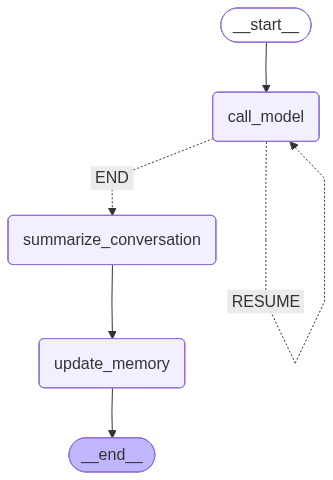

In [47]:
graph

In [48]:
# SQLite 스토어 인스턴스 생성
sqlite_store = SQLiteStore(db_path = 'example.db', embedding_model = model_name)

graph = builder.compile(checkpointer=memory, store=sqlite_store)

print('END를 입력하면 대화가 종료됩니다.')

config = {'configurable':{'thread_id':'1', 'user_id':'admin'}}
for data in graph.stream(
    {'messages':[]},
    config,stream_mode="updates"):
    print(data)

END를 입력하면 대화가 종료됩니다.
Assistant: 안녕하세요! 반갑습니다. 저는 고객님의 문의에 답변해 드리는 챗봇입니다. 😊

어떤 점을 도와드릴까요? 편하게 말씀해주세요!
네, 오늘은 2025년 10월 26일이고, 다음 주에 멤버십 혜택이 끝나는데, 자동 결제는 언제까지 가능한가요?
{'call_model': {'messages': [AIMessage(content='안녕하세요! 반갑습니다. 저는 고객님의 문의에 답변해 드리는 챗봇입니다. 😊\n\n어떤 점을 도와드릴까요? 편하게 말씀해주세요!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--c2bfc5e3-c967-481b-b4cf-0cd61744f8fb-0', usage_metadata={'input_tokens': 60, 'output_tokens': 310, 'total_tokens': 370, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 277}}), HumanMessage(content='네, 오늘은 2025년 10월 26일이고, 다음 주에 멤버십 혜택이 끝나는데, 자동 결제는 언제까지 가능한가요?', additional_kwargs={}, response_metadata={}, id='6282c379-64e2-4a72-8bb1-4b84a5b98eb9')]}}
Assistant: 고객님, 현재 날짜는 2025년 10월 26일 일요일이시군요. 다음 주에 멤버십 혜택이 종료된다고 말씀해주셨습니다.

멤버십 자동 결제는 **보통 혜택 종료일 당일에 이루어지거나, 종료일 1~3일 전에 미리 결제 시도가 

/tmp/ipython-input-4120135973.py:75: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().isoformat()


{'update_memory': None}


In [49]:
sqlite_store.list_namespaces()

[('admin', 'information')]

In [50]:
memories = sqlite_store.search(('admin', 'information'))
for result in memories:
    print(result)

Item(namespace=['admin', 'information'], key='ae82ea3b-ce5e-42be-a34e-870e32935c44', value={'memory': "2025년 10월 26일, 고객은 11월 1일에 멤버십 혜택이 종료되며 자동 결제를 해지하고 싶다고 문의했습니다. 챗봇은 멤버십 자동 결제가 보통 혜택 종료일 당일인 11월 1일 또는 그 전날인 10월 31일에 시도될 가능성이 높다고 안내했습니다. 자동 결제가 이루어지지 않도록 11월 1일 이전에 직접 멤버십 해지를 진행해야 한다고 설명하며, 웹사이트/앱의 '마이페이지'나 '계정 설정'에서 '멤버십 관리'를 통해 해지할 수 있는 일반적인 절차를 안내했습니다. 고객은 제공된 정보가 도움이 되었다고 밝혔습니다."}, created_at='2025-10-26T05:38:25.842755', updated_at='2025-10-26T05:38:25.842755', score=None)


In [51]:
# 임베딩 검색 사용 예시
# memory에서 값을 검색하도록 설정(SQLite Store Class 참고)

results = sqlite_store.search(('admin', 'information'), query="코딩", limit=1)
for result in results:
    print(result)


Item(namespace=['admin', 'information'], key='ae82ea3b-ce5e-42be-a34e-870e32935c44', value={'memory': "2025년 10월 26일, 고객은 11월 1일에 멤버십 혜택이 종료되며 자동 결제를 해지하고 싶다고 문의했습니다. 챗봇은 멤버십 자동 결제가 보통 혜택 종료일 당일인 11월 1일 또는 그 전날인 10월 31일에 시도될 가능성이 높다고 안내했습니다. 자동 결제가 이루어지지 않도록 11월 1일 이전에 직접 멤버십 해지를 진행해야 한다고 설명하며, 웹사이트/앱의 '마이페이지'나 '계정 설정'에서 '멤버십 관리'를 통해 해지할 수 있는 일반적인 절차를 안내했습니다. 고객은 제공된 정보가 도움이 되었다고 밝혔습니다."}, created_at='2025-10-26T05:38:25.842755', updated_at='2025-10-26T05:38:25.842755', score=np.float32(0.76328886))


Langsmith (https://smith.langchain.com )에서 실행 결과를 확인할 수 있습니다.